In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Getting Started with NVTabular: Process Tabular Data On GPU

This notebook is created using the latest stable [merlin-tensorflow](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/merlin/containers/merlin-tensorflow/tags) container. 

## Overview

[Merlin NVTabular](https://github.com/NVIDIA-Merlin/NVTabular) is a library for processing tabular data. It lets Data Scientists and ML Engineers easily process data leveraging custom operators specifically designed for machine learning workflows. The processing is carried out on the GPU with best practices baked into the library. Running on the GPU translates to faster iteration cycles and, thanks to leveraging `dask`, enables working on arbitrarily large datasets. NVTabular is a part of the [Merlin open source framework](https://developer.nvidia.com/nvidia-merlin) which allows for seamless transitioning to working with your preprocessed data using the numerous other libraries, including ones for model construction and serving.

Training a machine learning model ofen requires preprocessing data and engineering features. In this example, we want to train a neural network with embedding layers based on two categorical features: `userId` and `movieId`. Embedding layers require that the categorical features are continuous integers. In this example, we will show how to use the `Categorify` operator to transform the categorical features for training a model

Core features of Merlin NVTabular:
- Many different operators (`Categorify`, `FillMissing`, `TargetEncoding`, `Groupby`, etc) tailored for processing tabular data at scale
- Flexible APIs targeted to both production and research
- Deep integration with NVIDIA Merlin platform, including Merlin Models for constructing and training Deep Learning models and Merlin Systems for model serving


### Learning objectives

- Processing the Movielens dataset.
- Understanding Merlin NVTabular high-level concepts (Dataset, Workflow)
- A first look at operators and defining the preprocessing workflow

## Downloading the dataset

### MovieLens25M

The [MovieLens25M](https://grouplens.org/datasets/movielens/25m/) is a popular dataset for recommender systems and is widely used in academic publications. The dataset contains 25M movie ratings for 62,000 movies given by 162,000 users. Many projects use only the user/item/rating information of MovieLens, but the original dataset provides metadata for the movies, as well. For example, which genres a movie has.

To streamline obtaining data, we will use a function from Merlin Models.

In [2]:
import os
from merlin.datasets.entertainment import get_movielens

input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))
get_movielens(variant="ml-1m", path=input_path);

2022-08-31 04:04:15.362393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:04:15.362838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:04:15.362976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


The original dataset has been preprocessed to make it easier to work with. Instead of having to deal with `dat` files, we can read files directly into a `DataFrame` using the parquet format.

The data has already been split for us into train and validation sets.

In [3]:
ls {input_path}/ml-1m #noqa

README                    ratings.dat    users.dat
movies.dat                train.parquet  users_converted.parquet
movies_converted.parquet  transformed/   valid.parquet


In [4]:
from merlin.core.dispatch import get_lib

train = get_lib().read_parquet(f'{input_path}ml-1m/train.parquet')
valid = get_lib().read_parquet(f'{input_path}ml-1m/valid.parquet')

From the provided `train` and `validation` sets we will extract `userId`, `movieId` and `rating`.

In [5]:
train.head()

,userId,movieId,rating,timestamp
259658,1587,356,3,974740825
834974,5018,1299,4,962583606
153802,988,1721,4,976397962
363802,2119,151,4,974997851
834543,5015,1393,4,962594210


## Processing the dataset with NVTabular

### Defining the workflow

Before we can leverage `NVTabular`, we need to convert our data to a `Merlin Dataset`.

We achieve this by passing the `DataFrame` to the `Dataset` constructor.

In [6]:
import nvtabular as nvt
from merlin.schema.tags import Tags

train_ds = nvt.Dataset(train)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

(<merlin.io.dataset.Dataset at 0x7f39bce8b880>,
 <merlin.io.dataset.Dataset at 0x7f39bce8b820>)

Now that we have read in our data, let's define a workflow.

A workflow consists of one or more preprocessing steps that will be applied to our data.

We begin by converting `userId` and `movieId` columns to categories. In our dataset, they are already represented as integers, but many models require them to be continuous integers, which is not something we can guarantee about our input data if we don't preprocess it. Further to that, in order to train models on our data, we need to ensure we handle categories not seen in the train dataset.

We accomplish both of these with the `Categorify` operator.

In [7]:
output = ['userId', 'movieId'] >> nvt.ops.Categorify()

Above, we are instructing `NVTabular` to select the `userId` and `movieId` columns and to apply the `Categorify` operator to them. We store the results as `output`.

When we run the cell, the actual operation is not performed. Only a graph representation of the operation is created.

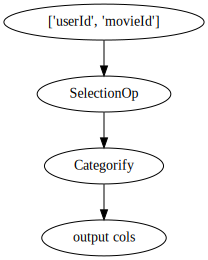

In [8]:
output.graph

Let us also add our target to the set of returned columns.

Additionally, we tag the `rating` column with appropriate tags. This will allow other components of the Merlin Framework to use this information and minimize the code we will have to write to perform complex operations such as training or serving a Deep Learning model.

If you would like to learn more about using `Tags`, take a look at the [NVTabular and Merlin Models integrated example](https://nvidia-merlin.github.io/models/main/examples/02-Merlin-Models-and-NVTabular-integration.html) notebook in the Merlin Models [repository](https://github.com/NVIDIA-Merlin/models).

In [9]:
output += ['rating'] >> nvt.ops.AddMetadata(tags=[Tags.REGRESSION, Tags.TARGET])

We are now ready to construct a `Workflow` that will run the operations we defined above.

In [10]:
workflow = nvt.Workflow(output)

### Applying the workflow to the train and validation sets

`NVTabular` follows the familiar `sklearn` API. We can fit the workflow to our train set and subsequently use it to transform our validation dataset.

In [11]:
workflow.fit_transform(train_ds).to_parquet('train')
workflow.transform(valid_ds).to_parquet('valid')

/usr/local/lib/python3.8/dist-packages/cudf/core/frame.py:384: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


We have `fit` our workflow to the train set. During this operation, the workflow computed and stored a mapping from `userId` and `movieId` values in the dataset to their encoded representation as continuous integers.

Subsequently, we have transformed the train set and encoded the `userId` and `movieId` columns (both operations were performed when we called `fit_transform`).

Last but not list, we transform our validation dataset using values computed on the train set.

We output both datasets to disk.

In [12]:
ls train

_file_list.txt  _metadata  _metadata.json  part_0.parquet  schema.pbtxt


Let us now load our transformed data and see whether everything looks as expected.

In [13]:
train_transformed = nvt.Dataset('train', engine='parquet')
valid_transformed = nvt.Dataset('valid', engine='parquet')

In [14]:
train_transformed.head()

,userId,movieId,rating
0,320,28,3
1,1278,354,4
2,3408,63,4
3,1747,569,4
4,204,99,4


Let's finish off this notebook with training a DLRM (a Deep Learning Recommendation Model introduced in [Deep Learning Recommendation Model for Personalization and Recommendation Systems](https://arxiv.org/abs/1906.00091)) on our preprocessed data.

To learn more about the integration between NVTabular and Merlin Models, please see the [NVTabular and Merlin Models integrated example](https://nvidia-merlin.github.io/models/main/examples/02-Merlin-Models-and-NVTabular-integration.html) in the Merlin Models [repository](https://github.com/NVIDIA-Merlin/models).

## Training a DLRM model

We define the DLRM model, whose prediction task is a binary classification. From the `schema`, the categorical features are identified (and embedded) and the target column is also automatically inferred, because of the schema tags. We talk more about the schema in the next example notebook, [Advanced NVTabular Workflow](02-Advanced-NVTabular-workflow.ipynb).

In [15]:
import tensorflow
import merlin.models.tf as mm

model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.RegressionTask('rating')
)

opt = tensorflow.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt)
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=5)

model.optimizer.learning_rate = 1e-4
metrics = model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=3)

2022-08-31 04:04:17.240242: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 04:04:17.241058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:04:17.241240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 04:04:17.241375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

Epoch 1/5
782/782 [==============================] - 6s 5ms/step - loss: 1.2843 - root_mean_squared_error: 1.1333 - regularization_loss: 0.0000e+00 - val_loss: 0.8349 - val_root_mean_squared_error: 0.9137 - val_regularization_loss: 0.0000e+00
Epoch 2/5
782/782 [==============================] - 4s 5ms/step - loss: 0.8268 - root_mean_squared_error: 0.9093 - regularization_loss: 0.0000e+00 - val_loss: 0.8105 - val_root_mean_squared_error: 0.9003 - val_regularization_loss: 0.0000e+00
Epoch 3/5
782/782 [==============================] - 3s 4ms/step - loss: 0.8017 - root_mean_squared_error: 0.8954 - regularization_loss: 0.0000e+00 - val_loss: 0.7988 - val_root_mean_squared_error: 0.8938 - val_regularization_loss: 0.0000e+00
Epoch 4/5
782/782 [==============================] - 3s 4ms/step - loss: 0.7863 - root_mean_squared_error: 0.8868 - regularization_loss: 0.0000e+00 - val_loss: 0.7915 - val_root_mean_squared_error: 0.8897 - val_regularization_loss: 0.0000e+00
Epoch 5/5
782/782 [=========

## Conclusion

NVTabular exposes operators tailored for processing tabular data at scale with machine learning best practices baked into the library. It tightly integrates with the rest of the Merlin Framework to streamline model construction, training and serving.

## Next steps

In subsequent notebooks, we will define more advanaced workflows and custom operators. We will also take a closer look at exporting NVTabular datasets and workflows at running in different environments (CPU, GPU and multi-GPU).